In [1]:
import tensorflow as tf

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np

In [5]:
import logging
logger=tf.get_logger()
logger.setLevel(logging.ERROR)

In [6]:
# Data Loading

In [7]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

68608000/68606236 [==============================] - 7s 0us/step


In [8]:
zip_dir_base=os.path.dirname(zip_dir) #has path name
!find $zip_dir_base -type d -print
 

FIND: Parameter format not correct


In [9]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

In [12]:
# Understanding Data

In [10]:
num_cats_tr=len(os.listdir(train_cats_dir))
num_dogs_tr=len(os.listdir(train_dogs_dir))

num_cats_val=len(os.listdir(validation_cats_dir))
num_dogs_val=len(os.listdir(validation_dogs_dir))

total_train=num_cats_tr+num_dogs_tr
total_val=num_cats_val+num_dogs_val

In [11]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [13]:
# Setting model parameters

In [14]:
BATCH_SIZE = 100  # Number of training examples to process before updating our models variables
IMG_SHAPE  = 150  # Our training data consists of images with width of 150 pixels and height of 150 pixels

In [15]:
# Data Preparation


In [18]:
train_image_generator=ImageDataGenerator(rescale=1./255)
validation_image_generator= ImageDataGenerator(rescale=1./255)

flow_from_directory method will load images from the disk, apply rescaling, and resize them using single line of code.

In [23]:
train_data_gen=train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                           directory=train_dir,
                                           shuffle=True,
                                           target_size=(IMG_SHAPE,IMG_SHAPE),
                                           class_mode='binary')

Found 2000 images belonging to 2 classes.


In [20]:
val_data_gen=validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=validation_dir,
                                                           shuffle=False,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE),
                                                           class_mode='binary')

Found 1000 images belonging to 2 classes.


In [21]:
# Visualise Training Images

In [24]:
sample_training_images, _=next(train_data_gen)

In [49]:
sample_test, _=next(val_data_gen)

The next function returns a batch from the dataset. One batch is a tuple of (*many images*, *many labels*). For right now, we're discarding the labels because we just want to look at the images.

In [25]:
def plotImages(images_arr):
    fig, axes=plt.subplots(1,5,figsize=(20,20))
    axes=axes.flatten()
    for img,ax in zip(images_arr,axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

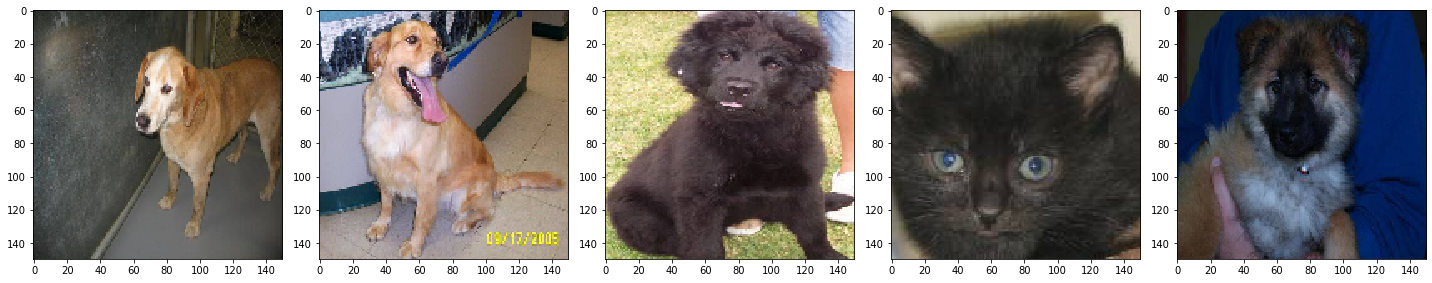

In [27]:
plotImages(sample_training_images[:5]) #plot images 0-4

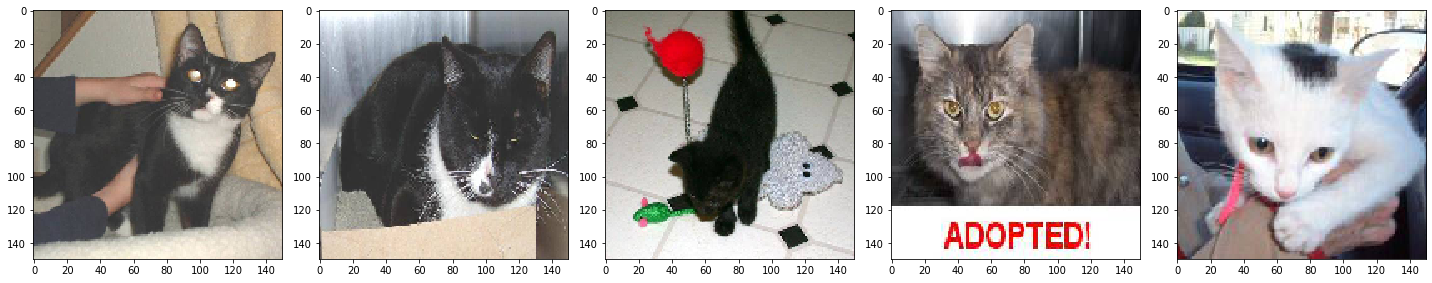

In [50]:
plotImages(sample_test[0:5])

In [28]:
# Model Creation

## Define the model

The model consists of four convolution blocks with a max pool layer in each of them. Then we have a fully connected layer with 512 units, with a `relu` activation function. The model will output class probabilities for two classes — dogs and cats — using `softmax`. 

In [32]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dense(2)
])

In [33]:
# Compile Model

 we will use the adam optimizer. Since we output a softmax categorization, we'll use sparse_categorical_crossentropy as the loss function. We would also like to look at training and validation accuracy on each epoch as we train our network, so we are passing in the metrics argument.

In [35]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [36]:
# Model Summary

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       1

In [39]:
# Train the model

Since our batches are coming from a generator (ImageDataGenerator), we'll use fit_generator instead of fit.

In [40]:
EPOCHS=20
history=model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train/float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val/float(BATCH_SIZE)))
)
    


Train for 20 steps, validate for 10 steps
Epoch 1/20
20/20 [==============================] - 37s 2s/step - loss: 0.7184 - accuracy: 0.5285 - val_loss: 0.6896 - val_accuracy: 0.6450
Epoch 2/20
20/20 [==============================] - 32s 2s/step - loss: 0.6857 - accuracy: 0.5640 - val_loss: 0.6600 - val_accuracy: 0.6320
Epoch 3/20
20/20 [==============================] - 33s 2s/step - loss: 0.6523 - accuracy: 0.6210 - val_loss: 0.6251 - val_accuracy: 0.6500
Epoch 4/20
20/20 [==============================] - 33s 2s/step - loss: 0.6322 - accuracy: 0.6235 - val_loss: 0.6233 - val_accuracy: 0.6170
Epoch 5/20
20/20 [==============================] - 34s 2s/step - loss: 0.5939 - accuracy: 0.6725 - val_loss: 0.5953 - val_accuracy: 0.6760
Epoch 6/20
20/20 [==============================] - 33s 2s/step - loss: 0.5468 - accuracy: 0.7150 - val_loss: 0.5868 - val_accuracy: 0.6950
Epoch 7/20
20/20 [==============================] - 33s 2s/step - loss: 0.5105 - accuracy: 0.7480 - val_loss: 0.5774 -

In [41]:
# Visualise Results of Training

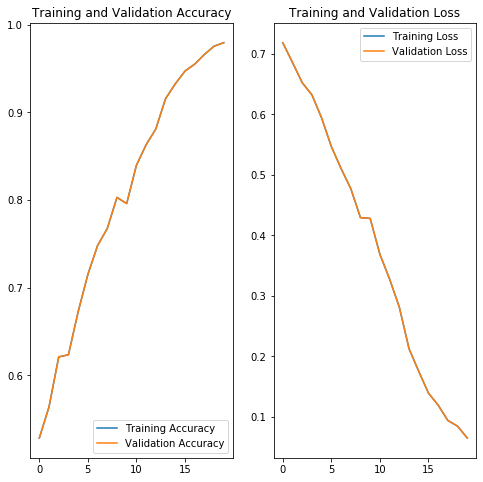

In [42]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(EPOCHS)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Training Accuracy')
plt.plot(epochs_range,acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Training Loss')
plt.plot(epochs_range,loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [94]:
def prediction(img):
    res=model.predict(img)
    l=len(res)
    for i in range (0,l):
            if(res[i][0]>res[i][1]):
                print(i+1,'Cat')
            else:
                print(i+1,'Dog')
            

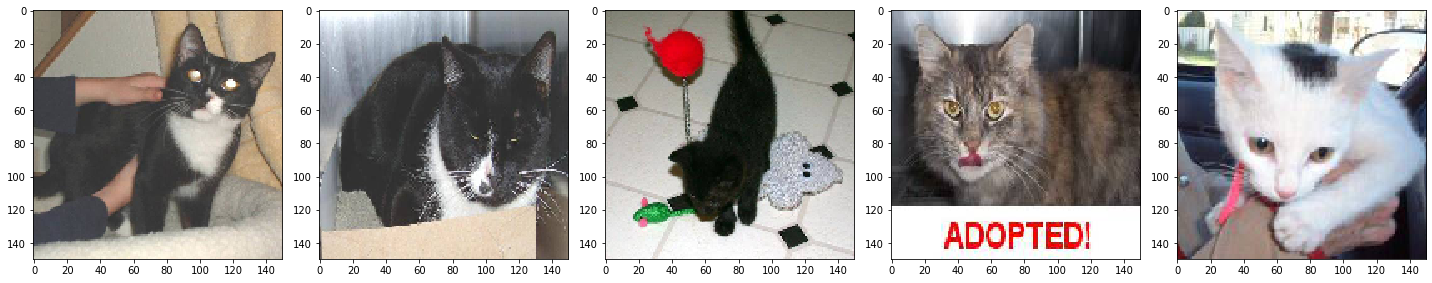

In [95]:
plotImages(sample_test[:5])

In [96]:
prediction(sample_test[:5].reshape([5,150,150,3]))

1 Cat
2 Dog
3 Cat
4 Cat
5 Cat


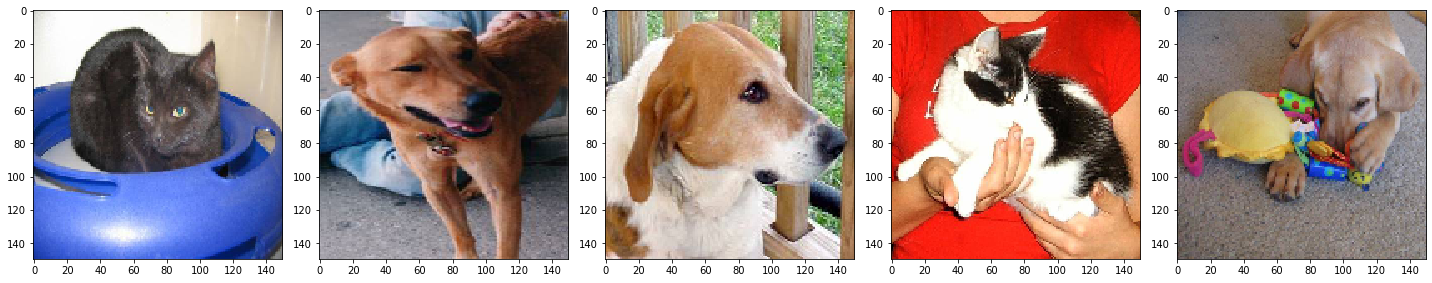

In [97]:
plotImages(sample_training_images[8:13])

In [98]:
prediction(sample_training_images[8:13].reshape([5,150,150,3]))

1 Cat
2 Dog
3 Dog
4 Cat
5 Dog
